# Extract topics  of  NSF OCE awards & compute t-SNE embedding vectors 
Created by Ivan Lima on Fri Jan 19 2018 09:10:18 -0500

Last modified on Thu Aug 16 2018 16:51:04 -0400

**In this notebook we apply Latent Dirichlet Allocation (LDA) to abstracts from NSF-OCE awards from 1985 to 2018 to extract 20 research topics, and compute the t-SNE embedding vectors to visualize the distribution of awards in topic space.** 

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

## Read data

In [2]:
store = pd.HDFStore('data/nsf_oce_awards_1985-2017.h5')
awards = store['awards']
store.close()
nyears = len(awards.StartDate.dt.year.unique())
# awards = awards.sort_values('StartDate')

**Number of awards per year**

In [3]:
pd.DataFrame(awards.groupby(by=awards.StartDate.dt.year)['Abstract'].count())

,Abstract
StartDate,
1985,2
1986,2
1987,239
1988,321
1989,323
1990,414
1991,524
1992,387
1993,394


**Model parameters & function definitions**

In [4]:
abstracts = awards.Abstract.values.tolist() # list of abstracts to analyze
n_topics = 20      # number of topics to extract
n_top_words = 20   # number of top words per topic

def top_abstracts(xtopic, topic_number, n_abstracts=5, n_sentences=5):
    """ Show first n_sentences of top n_abstracts for given topic number """
    sort_abstracts = np.argsort(xtopic[:,topic_number])[::-1] # descending order
    print('Topic {}:'.format(topic_number))
    for n in sort_abstracts[:n_abstracts]:
        print('\n{} ...'.format('. '.join(abstracts[n].split('.')[:n_sentences])))

## Lemmatization & stemming functions

In [5]:
import re
import nltk
import spacy
from spacy.tokens import Doc

regexp = re.compile('(?u)\\b\\w\\w+\\b') # same tokenizer as in CountVectorizer

# custom tokenizer with nltk stemming
stemmer = nltk.stem.PorterStemmer()
def tokenizer_stem(doc):
    return [stemmer.stem(token.lower()) for token in regexp.findall(doc)]

# custom tokenizer with nltk lemmatization
stemmer_lemm = nltk.stem.WordNetLemmatizer()
# nltk.download('wordnet',download_dir='/opt/miniconda3/nltk_data')
def tokenizer_stemlemm(doc):
    return [stemmer_lemm.lemmatize(token.lower()) for token in regexp.findall(doc)]

# custom tokenizer with spacy lemmatization
nlp = spacy.load('en')
old_tokenizer = nlp.tokenizer
nlp.tokenizer = lambda string: Doc(nlp.vocab, words=regexp.findall(string)) # replace spacy tokenizer with regexp
def tokenizer_lemm(doc):
    doc_spacy = nlp(doc)
    return [token.lemma_ for token in doc_spacy]

## Convert list of abstracts to bag-of-words matrix

**Note:** LDA is quite sensitive to the input data. Relatively small changes in the parameters for the *bag-of-words* can change some of the topics extracted.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(stop_words='english', min_df=3, max_df=0.15, tokenizer=tokenizer_lemm).fit(abstracts)
X = tf_vectorizer.transform(abstracts)
feature_names = np.array(tf_vectorizer.get_feature_names())
print('X: {}'.format(repr(X)))

X: <11238x12970 sparse matrix of type '<class 'numpy.int64'>'
	with 869857 stored elements in Compressed Sparse Row format>


**Most frequent & least frequent words**

In [7]:
max_freq = X.toarray().sum(axis=0) # frequency accross all abstracts
sort_freq = np.argsort(max_freq)
print('Features with highest frequency:\n{}'.format(feature_names[sort_freq[-25:]]))
print('\nFeatures with lowest frequency:\n{}'.format(feature_names[sort_freq[:25]]))

Features with highest frequency:
['different' 'interaction' 'source' 'north' 'condition' 'ridge'
 'variability' 'chemical' 'production' 'level' 'coral' 'transport'
 'population' 'organic' 'atlantic' 'equipment' 'wave' 'vessel'
 'temperature' 'ecosystem' 'specie' 'circulation' 'flow' 'flux' 'coastal']

Features with lowest frequency:
['connell' 'complexing' 'peggy' 'complementarity' 'competitiveness'
 'perfectly' 'peridotitic' 'perimeter' 'peristaltic' 'permeation'
 'peroxidation' 'perplexing' 'compacting' 'personally' 'pervade'
 'peculiarity' 'commonwealth' 'pew' 'phasing' 'comfortable' 'phenology'
 'phenomenological' 'comb' 'phenylalanine' 'philadelphia']


## Extract topics using LDA

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=25, n_jobs=-1, random_state=0)
X_topics = lda.fit_transform(X)
awards['topic'] = np.argmax(X_topics,axis=1)
awards['topic_prob'] = X_topics.max(axis=1)

**Top 20 most frequent words in each topic**

In [9]:
sort_by_feature = np.argsort(lda.components_,axis=1)[:,::-1] # descending order
cols = ['topic {:d}'.format(i) for i in range(lda.components_.shape[0])]
df_topics = pd.DataFrame(feature_names[sort_by_feature][:,:n_top_words].transpose(), columns=cols)
topic_names = np.array(['{} {:2d}'.format(' '.join(words),n) for n, words in 
                        enumerate(feature_names[sort_by_feature[:,:3]])])
topic_names_r = ['{} {}'.format(s.split()[-1], ' '.join(s.split()[:3])) for s in topic_names]
df_topics

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19
0,sensor,coral,workshop,record,hydrothermal,temperature,organic,wave,population,vessel,production,microbial,ecosystem,gulf,specie,ridge,circulation,coastal,seismic,trace
1,instrument,reef,education,core,vent,depth,matter,flow,fish,equipment,nitrogen,phytoplankton,coastal,gas,population,mantle,atlantic,shelf,margin,element
2,technology,host,international,past,fluid,series,compound,eddy,larval,operate,nutrient,cell,human,oil,predator,spread,variability,transport,earthquake,isotope
3,capability,ecosystem,school,isotope,ridge,mooring,dissolve,numerical,zooplankton,ship,oxygen,bacteria,environmental,co2,prey,seismic,north,river,subduction,particle
4,design,acidification,national,proxy,melt,cruise,doc,layer,specie,instrumentation,iron,growth,management,day,genetic,crust,basin,estuary,zone,metal
5,observatory,disease,oceanography,carbonate,rock,profile,chemical,mix,larvae,shipboard,flux,gene,level,mexico,behavior,plate,southern,flow,fault,tracer
6,instrumentation,temperature,experience,temperature,chemical,hydrographic,source,turbulence,recruitment,instrument,cycle,molecular,resource,total,animal,mid,atmospheric,wind,event,flux
7,vehicle,specie,public,glacial,mantle,salinity,dom,internal,bank,operation,fe,organism,public,proposal,organism,crustal,observation,plume,plate,concentration
8,situ,ph,opportunity,level,temperature,deploy,material,energy,abundance,share,primary,specific,health,spill,interaction,oceanic,heat,continental,drilling,geotrace
9,available,increase,participate,isotopic,geochemical,station,composition,flux,growth,acquisition,biogeochemical,diversity,lake,air,pattern,tectonic,flux,estuarine,deformation,seawater


**Look at top $n$ abstracts for given topic**

In [10]:
# top_abstracts(X_topics,3)

### Frequency of awards per topic (topic weights)

<IPython.core.display.Javascript object>


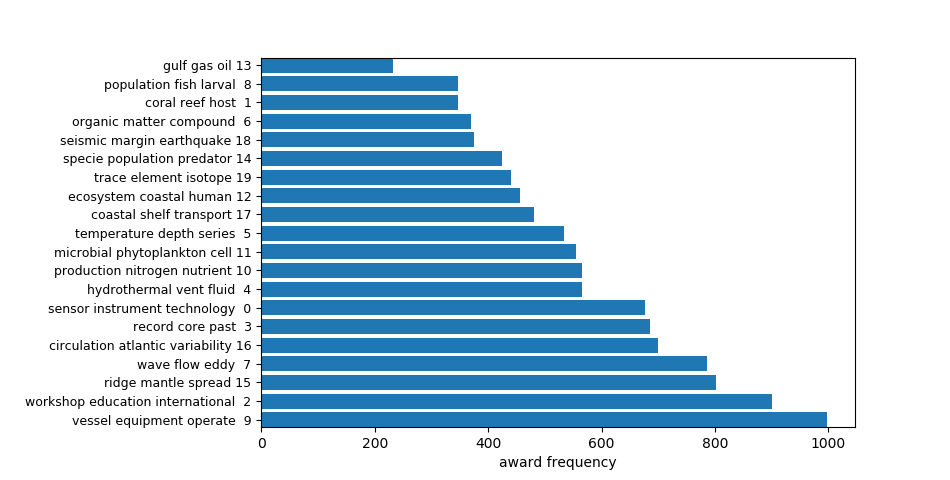

In [11]:
topic_freq = X_topics.sum(axis=0)
sort_by_weight = np.argsort(topic_freq)[::-1]  # descending order

fig, ax = plt.subplots(figsize=(9.5,4.8))
fig.subplots_adjust(left=0.275)
_ = ax.barh(range(n_topics),topic_freq[sort_by_weight])
_ = ax.set(xlabel='award frequency')
_ = ax.set_yticks(range(n_topics))
_ = ax.set_yticklabels(topic_names[sort_by_weight],fontsize=9)
ax.autoscale(axis='y',tight=True)

### Word frequency in each topic (topic loads)

<IPython.core.display.Javascript object>


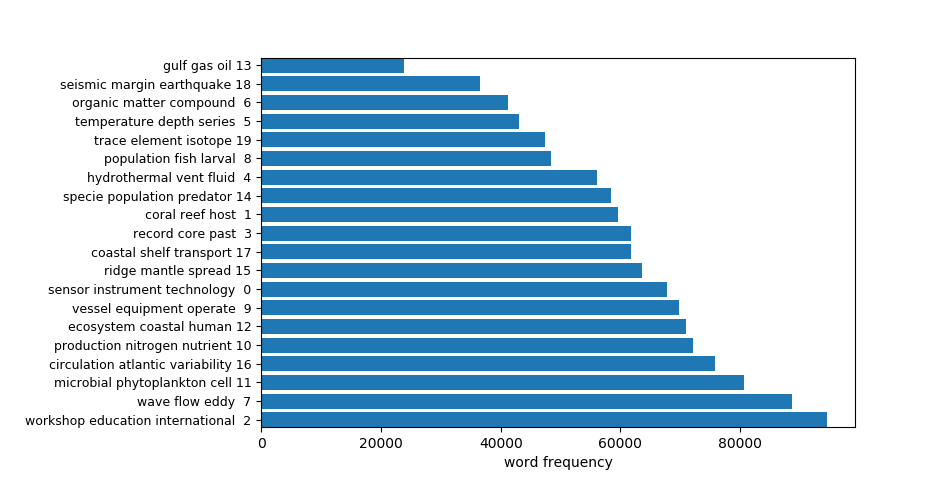

In [12]:
topic_loads = lda.components_.sum(axis=1)
sort_by_load = np.argsort(topic_loads)[::-1] # descending order

fig, ax = plt.subplots(figsize=(9.5,4.8))
fig.subplots_adjust(left=0.275)
_ = ax.barh(range(n_topics),topic_loads[sort_by_load])
_ = ax.set(xlabel='word frequency')
_ = ax.set_yticks(range(n_topics))
_ = ax.set_yticklabels(topic_names[sort_by_load],fontsize=9)
ax.autoscale(axis='y',tight=True)

## Estimate award interdisciplinarity using Pielou's evenness/diversity index 

In [13]:
p = np.repeat(np.array(1/n_topics),n_topics)
Hmax = (-p * np.log(p)).sum()
H = (-X_topics * np.log(X_topics)).sum(axis=1)
awards['evenness'] = H/Hmax

## Compute t-SNE embedding vectors

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X_topics)

<IPython.core.display.Javascript object>


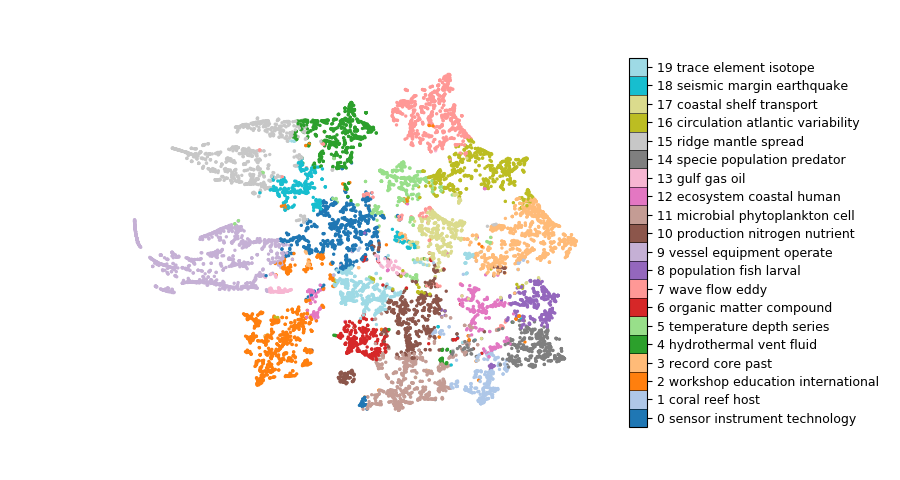

In [15]:
fig, ax = plt.subplots(figsize=(9,4.8))
fig.subplots_adjust(right=0.8)
sp = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=2, c=awards.topic.values, cmap=plt.cm.tab20, alpha=1)
ax.axis('off')
cb = fig.colorbar(sp,ax=ax,values=range(n_topics),boundaries=range(n_topics+1),ticks=np.arange(0.5,n_topics+0.5),
                  drawedges=True)
cb.set_ticklabels(topic_names_r)
cb.ax.tick_params(labelsize=9)

## Save results to file

In [16]:
np.savez_compressed('results/tf_lda_tsne',
                    X=X.toarray(),
                    feature_names=feature_names,
                    lda_components=lda.components_,
                    X_topics=X_topics,
                    X_tsne=X_tsne)

store = pd.HDFStore('results/tf_lda_awards_topics.h5',complevel=9)
store['awards'] = awards
store.close()